In [11]:
import gensim
import os
from gensim.models.word2vec import Word2Vec, PathLineSentences
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

class OneHot(object):
    def __init__(self):
        self.__label_encoder = LabelEncoder()
        self.__onehot_encodeder = OneHotEncoder()

    def encode(self, target_list):
        integer_encoded = self.__label_encoder.fit_transform(np.array(target_list))
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        self.__onehot_encodeder = self.__onehot_encodeder.fit_transform(integer_encoded)
        return self.__onehot_encodeder.toarray()

    def encode_label(self, target_list):
        integer_encoded = self.__label_encoder.fit_transform(np.array(target_list))
        return integer_encoded

    def decode(self, encoder_list):
        return self.__label_encoder.inverse_transform([np.argmax(np.array(encoder_list), axis=1)])


def read_file_to_corpus(folder):
    corpus = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), encoding="utf-8") as f:
            for line in f:
                corpus.append(line.split())
    return corpus



def get_vec_model(model_path):
    vec_model = gensim.models.Word2Vec.load(model_path)
    return vec_model


def get_train_list(source_folder, target_folder):
    source_string = []
    target_string = []
    for filename in os.listdir(source_folder):
        target_file_name = "targetH_" + "_".join(filename.split("_")[1:])
        if os.path.exists(os.path.join(target_folder, target_file_name)):
            with open(os.path.join(source_folder, filename), encoding="utf-8") as source:
                with open(os.path.join(target_folder, target_file_name), encoding="utf-8") as target:
                    for source_line in source:
                        for target_line in target:
                            if len(source_line.split()) == len(target_line.split()):
                                source_string.append(source_line.split())
                                target_string.append(target_line.split())
    return source_string, target_string

In [12]:
def get_train_feature(source_string, vec_model, max_sequence=1000):
    index2word_set = set(vec_model.wv.index2word)
    row_vector_list = []
    for source_line in source_string:
        i = 0
        row_vector = []
        for source_word in source_line:
            if i < max_sequence:
                if source_word in index2word_set:
                    row_vector= np.append(row_vector, vec_model[source_word])
                else:
                    row_vector = np.append(row_vector, np.zeros(vec_model.trainables.layer1_size, dtype='float32'))
            i += 1
        if len(source_line) < max_sequence:
            row_vector = np.append(row_vector,
                                   np.zeros((vec_model.trainables.layer1_size * (max_sequence - len(source_line)),),
                                            dtype='float32'))
        print(row_vector.shape)
        row_vector_list.append(row_vector)
    print(np.array(row_vector_list).shape)
    return np.matrix(row_vector_list)


In [13]:
def get_target_label(target_string,max_sequence=1000):
    onehot_model = OneHot()
    for i in range(0, len(target_string)):
        if len(target_string[i]) < max_sequence:
            target_string[i] = target_string[i].extend(["O"]*(max_sequence - len(target_string[i])))
            if target_string[i] is None:
                target_string[i] = ["O"]*max_sequence
        else:
            if target_string[i] is None:
                target_string[i] = ["O"]*max_sequence
            else:
                target_string[i] = target_string[i][0:max_sequence]
    num_rows = len(target_string)
    flat_list = [item for sublist in target_string for item in sublist]
    target_vector = onehot_model.encode_label(flat_list)
    target_vector = target_vector.reshape(-1, max_sequence)
    return target_vector, onehot_model


In [14]:
import gensim
import os
from gensim.models.word2vec import Word2Vec, PathLineSentences
import numpy as np
def get_train_list(source_folder, target_folder):
    source_string = []
    target_string = []
    for filename in os.listdir(source_folder):
        target_file_name = "targetH_" + "_".join(filename.split("_")[1:])
        if os.path.exists(os.path.join(target_folder, target_file_name)):
            with open(os.path.join(source_folder, filename), 'r', encoding="utf-8") as source:
                with open(os.path.join(target_folder, target_file_name), 'r', encoding="utf-8") as target:
                    for source_line, target_line in zip(source.readlines(), target.readlines()):
                        s_line = source_line.split()
                        t_line = target_line.split()
                        if len(s_line) == len(t_line):
                            source_string.append(s_line)
                            target_string.append(t_line)
    print('源数据读取完毕，共' + str(len(source_string)) + '行')
    return source_string, target_string


In [15]:
def get_vec_from_corpus(corpus, size=128, min_count=2, save_path=os.path.join("./data/ner_word2vec_model")):
    vec_model = Word2Vec(sentences=corpus, size=size, min_count=min_count)
    vec_model.save(save_path)
    return vec_model


In [16]:
def lstm_crf(X):
    embedding_size = 128
    unit_num = 128
    dropout_rate = None
    output_size = 3
    batch_size = 1
    seq_length = 10
    lr = 0.001

    cell_forward = tf.nn.rnn_cell.BasicLSTMCell(unit_num)
    cell_backward = tf.nn.rnn_cell.BasicLSTMCell(unit_num)
    input_bi_lstm = tf.reshape(X, [batch_size, seq_length, embedding_size])
    bi_outputs, bi_state = tf.nn.bidirectional_dynamic_rnn(cell_forward,
                                    cell_backward, input_bi_lstm, dtype=tf.float32)

    bi_output = tf.concat(bi_outputs, axis=2)

    W = tf.get_variable("projection_w", [2 * unit_num, output_size])
    b = tf.get_variable("projection_b", [output_size])
    x_reshape = tf.reshape(bi_output, [-1, 2 * unit_num])
    projection = tf.matmul(x_reshape, W) + b
    outputs = tf.reshape(projection, [batch_size, seq_length, output_size])
    return outputs


In [17]:
def train(feature, target, save_path, iter_num):
    embedding_size = 128
    unit_num = 128
    dropout_rate = None
    output_size = 3
    batch_size = 1
    seq_length = 10
    lr = 0.001

    X = tf.placeholder(tf.float32, shape=[batch_size, seq_length*embedding_size])
    Y = tf.placeholder(tf.int32, shape=[batch_size, seq_length])
    pred = lstm_crf(X)
    real_y = tf.reshape(Y, [batch_size, seq_length])
    log_likelihood, transition_params = tf.contrib.crf.crf_log_likelihood(pred, real_y, tf.convert_to_tensor(batch_size * [seq_length], dtype=tf.int32))
    sess = tf.Session()
    # Add a training op to tune the parameters.
    loss = tf.reduce_mean(-log_likelihood)
    train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
    sess.run(tf.global_variables_initializer())
    total_loss = []

    for i in range(iter_num):
        for step in range(int(feature.shape[0]/batch_size)-1):
            tf_unary_scores, tf_transition_params, _, loss_ = sess.run([pred, transition_params, train_op, loss],
                                                                       feed_dict={X: feature[step*batch_size:(step+1)*batch_size],
                                                                                  Y: target[step*batch_size:(step+1)*batch_size]})
        total_loss.append(loss_)
        if i % 50 == 0:
            print("迭代第：" + str(i) + "次， Loss为：" + str(loss_))
        if i % 100 == 0:
            print("保存模型：", saver.save(sess, save_path, global_step=i))
    return total_loss

In [18]:
source_string, target_string = get_train_list("./data/source","./data/target")
print(source_string, target_string)
vec_model = get_vec_from_corpus(source_string, min_count=1)
target_vector, onehot_model = get_target_label(target_string, max_sequence=10)
feature = get_train_feature(source_string, vec_model, max_sequence=10)

源数据读取完毕，共2行
[['初见', '安迪苏', '(', 'SH', '：', '600299', ')', '是', '前', '阵子', '看到', '这样', '一则', '新闻', '：6', '月', '30', '日讯', '，', '坊间', '传闻', '近两年', '的', '中国', '化工集团', '与', '中化', '集团', '合', '并', '交易', '终于', '坐实', '，', '中国', '化工', '董事长', '任建新', '宣布', '退休', '，', '中化', '集团董事长', '宁高宁', '担任', '合', '并', '后', '公司', '的', '董事长', '，', '中组部', '和', '国资委', '相关', '负责人', '到', '中国', '化工集团', '宣布', '了', '上述', '公司', '合', '并', '与', '人事安排', '。', '（', '财新网', '）根据', '公开', '信息', '可知', '，', '中国', '中化', '集团公司', '和', '中国', '化工', '集团公司', '旗下', '上市公司', '包括', '：', '中化国际', '(', 'SH', ':', '600500', ')', '、', '沈阳化工', '(', 'SZ', ':', '000698', ')', '、', '风神股份', '(', 'SH', ':', '600469', ')', '、', '江山股份', '(', 'SH', ':', '600389', ')', '、', '天科股份', '(', 'SH', ':', '600378', ')', '、', '扬农化工', '(', 'SH', ':', '600486', ')', '、', '沧州大化', '(', 'SH', ':', '600230', ')', '、', '天华院', '(', 'SH', ':', '600579', ')', '、', '安迪苏', '等', '。这', '其中', '提到', '的', '公司', '中', '，', '我', '只', '研究', '并', '买', '过', '扬农化工', '（', '目前', '已', '清仓', 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [19]:
tf.reset_default_graph()
total_loss = train(feature, target_vector, "./model/bilstm", 500)

迭代第：0次， Loss为：12.342257
保存模型： ./model/bilstm-0
迭代第：50次， Loss为：1.7040482
迭代第：100次， Loss为：1.1968918
保存模型： ./model/bilstm-100
迭代第：150次， Loss为：0.34449005
迭代第：200次， Loss为：0.053741455
保存模型： ./model/bilstm-200
迭代第：250次， Loss为：0.020721436
迭代第：300次， Loss为：0.011787415
保存模型： ./model/bilstm-300
迭代第：350次， Loss为：0.007827759
迭代第：400次， Loss为：0.0056381226
保存模型： ./model/bilstm-400
迭代第：450次， Loss为：0.0043182373


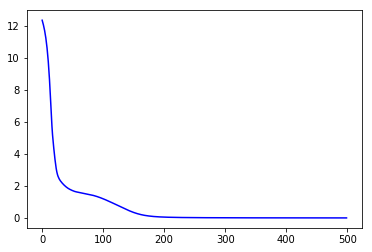

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(range(len(total_loss))), total_loss, color='b')
plt.show()